<a href="https://colab.research.google.com/github/Carhuacusma/CC61_PDI_Trabajo_Final/blob/main/CC61_PDI_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CC61: Procesamiento de Imágenes
#**Trabajo Final**

Alumnos:
* Galván Díaz, Joaquín Adrían : u201810A.
* Moreno Carhuacusma, Dante Brandon : u201818067

## Objetivos

* Distinguir una partitura musical en una imagen
* Extraer el sonido que correspone a los símbolos en la partitura
* Determinar el mejor acercamiento con técnicas de procesamiento al problema

## Desarrollo

###Importación de librerías

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
#No da error en colab pero no funciona el import {simbolo de exclamcion} pip install scikits.audiolab

In [ ]:
#from scikits.audiolab import play

In [ ]:
repo = "https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/"

In [ ]:
ruta = "Fotos/mary_hoja.jpg"
imHoja = io.imread("%s%s"%(repo,ruta))
print(type(imHoja))

<class 'numpy.ndarray'>


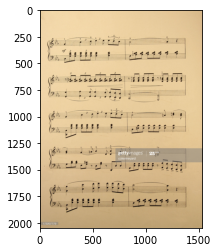

In [ ]:
imagen = io.imread("https://media.gettyimages.com/photos/antique-sheet-music-picture-id172207779?s=2048x2048") #..Considerar: io.imread lee en RGB
#.........................................................cv2 imshow es en BGR
plt.imshow(imagen)

###Preprocesamiento: Rectificar la imagen

In [ ]:
def ordenarEsquinas(pts):
  rect = np.zeros((4, 2), dtype = "float32") # Rectángulo de 0s para ser como un canvas
  oAux = pts.sum(axis = 1) # Arreglo de 4 resultados...................................... : oAux[i] = pts[i][0] + pts[i][1]
  rect[0] = pts[np.argmin(oAux)] # La esquina superior izquierda tiene la suma más pequeña
  rect[2] = pts[np.argmax(oAux)] # La esquina inferior derecha tiene la mayor suma
  oAux = np.diff(pts, axis = 1)  # ....................................................... : oAux[i] = |(pts[i][0] - pts[i][1])|
  rect[1] = pts[np.argmin(oAux)] # La esquina superior derecha minima diferencia (X mayor)
  rect[3] = pts[np.argmax(oAux)] # La esquina inferior izquierda maxima diferencia
  return rect

In [ ]:
def enCasoHoja(imagen,contornos,umbralHoja = 0.5):
  contornos = contornos[:int(0.15*len(contornos))] #............................ 1. Extrae el 15 % de contornos con mayor área
  candHoja = []
  auxArea = 0
  for c in contornos: #..................................... 2. Por cada C que pertenece a Contornos:
    perimetro = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.015 * perimetro, True) #......2.1. Disminuir el número de lados de C (Polígono Aproximado)
    if len(approx) == 4: #.......................................2.2. Si el approx es de 4 lados:
      auxArea = cv2.contourArea(approx) #................................ Considera el Área del "candidato a hoja"
      if auxArea/((imagen.shape[0])*(imagen.shape[1])) > umbralHoja: #... Si la proporción área de candidato/imagen supera el umbral:
        candHoja = approx #................................................... "Candidato" es hoja
        break
  if len(candHoja) == 0:
    print("En la imagen no se ve una hoja")
    return imagen
  else:
    puntos = candHoja.reshape(4, 2) # Para manejar mejor los puntos
    rect = ordenarEsquinas(puntos)
    (tl, tr, br, bl) = rect # Ordenar esquinas (Sup Izq, Sup Der, Inf Der, Inf Izq) AKA en formato HORARIO
    # Define el rectángulo objetivo (y las dimensiones del rectangulo recto y posicionado)
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2)) #... Distancia euclidiana
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2)) #... ""
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) #.. ""
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) #.. ""
    maxWidth = max(int(widthA), int(widthB)) #......... Los máximos se usan para la nueva image
    maxHeight = max(int(heightA), int(heightB)) #...... ""
    # dst: Puntos de destino, imagen "recta" (NO NECESARIAMENTE CORRECTAMENTE)
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst) # Matriz de transformación
    return cv2.warpPerspective(imagen, M, (maxWidth, maxHeight)) # Warp como tal

In [15]:
def rectificar(imagen, umbralHoja = 0.5):
  if len(imagen.shape) != 2:
    imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY) #....................| 1. Asegura Escala de Grises, 
  imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30) # .| 2. Blur, 
  im_canny = cv2.Canny(imagen,50,205) #...................................| 3. Edge Detector: Canny >> Imagen con bordes
  contornos, _ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #...| 1. Extrae "Contornos" con Cadena (findContours) 
  contornos = sorted(contornos, key = cv2.contourArea, reverse = True) #..............| 2. Ordenar "Contornos" por Área
  imagen = enCasoHoja(im_canny,contornos,umbralHoja) #................................| 3. De ser necesario, extrae solo la hoja impresa de la imagen 
  # TODO: Hough de Líneas,
  # -> Flip x° para que el pentagrama encaje  
  return imagen

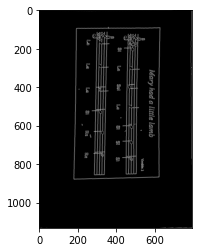

In [17]:
plt.imshow(rectificar(imHoja,0.5),cmap='gray')

En la imagen no se ve una hoja


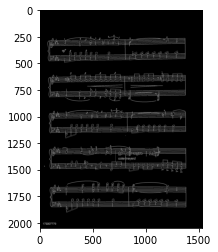

In [18]:
plt.imshow(rectificar(imagen,0.5),cmap='gray')

In [ ]:
#https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed 
#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
#sigmaSpace alto podría terminar borrando detalles y no queremos eso porque líneas
#d=3 porque tampoco queremos un blur tan fuerte
imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30)